In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import sklearn as sk
import os
import random
import math
import datetime


In [38]:
tf.test.is_built_with_cuda()

True

In [39]:
IMG_SIZE = 224

PATH = "video_data/surveillance_dataset/"

In [40]:
def video_to_frames(p):
    #assert os.path.exists(p)
    cap = cv2.VideoCapture(p)
    
    #assert cap
    rate = math.floor(cap.get(3))

    ImageFrames = []
    #assert cap.isOpened()
    

    '''make sure to figure out how to extract a certain amount of frames so you don't use too much memory'''
    while cap.isOpened():
        #ID = cap.get(1)
        
        success, image = cap.read()
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        mid = int(n_frames/2)
        first_q = int(n_frames/4)
        third_q = int(n_frames * .75)
        end = n_frames
        #print(n_frames)
        #assert success

        if success:

            for frame in range(n_frames):
                if frame == first_q or frame == mid or frame == third_q or frame == end:
                    
                    
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    ImageFrames.append(image)
                else: continue
            cap.release()
    #print("successful frame capture")
            return ImageFrames

        else: 
            break

In [41]:
CATEGORIES = ["fight", "noFight"]
X_set = []
y_set = []
for category in os.listdir(PATH):
    
    
    path = os.path.join(PATH, category)
    #print(path)
    #assert os.path.exists(path)


    class_num = CATEGORIES.index(category)
    for i, video in tqdm(enumerate(os.listdir(path)), total=len(os.listdir(path))):

        #print(path + '/' + video)
        #print(os.path.join(path, video))
        frames = video_to_frames(path + '/' + video)
        if frames:
        
            for j, frame in enumerate(frames):
                X_set.append(frame)
                y_set.append(class_num)
        else: continue

            
print("success")

100%|██████████| 150/150 [00:02<00:00, 56.67it/s]

success


In [42]:
X_set = np.array(X_set).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_set = np.array(y_set)
len(X_set), len(y_set)

(900, 900)

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2)

for train_index, test_index in stratified_sample.split(X_set, y_set):
    X_train, X_test = X_set[train_index], X_set[test_index]
    y_train, y_test = y_set[train_index], y_set[test_index]

In [44]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
# X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

y_train = np.asarray(y_train)
y_test_nn = np.asarray(y_test)
# y_val = np.asarray(y_val)

In [45]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train, y_train, 16)
test_gen = DataGenerator(X_test_nn, y_test_nn, 16)
# val_gen = DataGenerator(X_val, y_val, 16)

In [46]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input

In [47]:
from tensorflow.keras import Sequential, layers

# data_augmentation = Sequential(
#     [
#         layers.RandomFlip("horizontal_and_vertical"),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#         layers.RandomContrast(factor=0.1),
#         layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#     ],
#     name="img_augmentation"
# )
data_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation"
)

In [48]:
def build_model(input_shape, data_aug, trainable=True, dropout=0.5):
        inputs = keras.Input(shape=input_shape)
        x = data_aug(inputs)
        x = preprocess_input(x)

        baseModel = MobileNetV2(weights=None, 
                                   pooling='avg',
                                   include_top=False, 
                                   input_tensor=x)
        baseModel.trainable = trainable

        headModel = baseModel.output
        headModel = layers.Dropout(dropout)(headModel)

        outputs = layers.Dense(1, activation="sigmoid")(headModel) # formerly outputs = 

        #headModel = layers.GlobalAveragePooling2D()(headModel)
        model = Model(inputs = baseModel.input, outputs=outputs)

        return model

# Fine Tuning

In [49]:
#empty for now

In [62]:
MobNet = build_model(input_shape=(224,224) + (3,),
                     data_aug= data_augmentation,
                     trainable=True,
                     dropout=0.2)

In [63]:
from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.0001)
    
]

In [64]:
mets = ['binary_accuracy', 'acc']
loss = tf.keras.losses.BiaryCrossentropy(from_logits=True)
MobNet.compile(loss=loss,
               optimizer='adam',
               metrics=mets)


In [65]:
start_time = datetime.datetime.now()
history = MobNet.fit(train_gen,
                     batch_size=4,
                     epochs=25, 
                     steps_per_epoch= len(train_gen),
                    #  callbacks= callbacks,
                     #validation_data=val_gen,                    
                     verbose=1)

print("Training Complete.")
end_time = datetime.datetime.now()
print(f"Training time: {end_time - start_time}")

Epoch 1/25
45/45 [==============================] - 10s 110ms/step - loss: 0.7876 - binary_accuracy: 0.5056 - acc: 0.5056
Epoch 2/25
45/45 [==============================] - 5s 111ms/step - loss: 0.7575 - binary_accuracy: 0.5028 - acc: 0.5028
Epoch 3/25
45/45 [==============================] - 5s 110ms/step - loss: 0.7353 - binary_accuracy: 0.4986 - acc: 0.4986
Epoch 4/25
45/45 [==============================] - 5s 110ms/step - loss: 0.7273 - binary_accuracy: 0.4972 - acc: 0.4972
Epoch 5/25
45/45 [==============================] - 5s 111ms/step - loss: 0.7081 - binary_accuracy: 0.5250 - acc: 0.5250
Epoch 6/25
45/45 [==============================] - 5s 110ms/step - loss: 0.7110 - binary_accuracy: 0.5000 - acc: 0.5000
Epoch 7/25
45/45 [==============================] - 5s 112ms/step - loss: 0.6893 - binary_accuracy: 0.5278 - acc: 0.5278
Epoch 8/25
45/45 [==============================] - 5s 110ms/step - loss: 0.6968 - binary_accuracy: 0.5181 - acc: 0.5181
Epoch 9/25
45/45 [=============

In [66]:
def eval_model(model):
    acc = model.evaluate(test_gen)
    print("This model's accuracy is:", round(acc[1], 4)*100 , "%")


eval_model(MobNet)

12/12 [==============================] - 1s 23ms/step - loss: 0.6976 - binary_accuracy: 0.5000 - acc: 0.5000
This model's accuracy is: 50.0 %


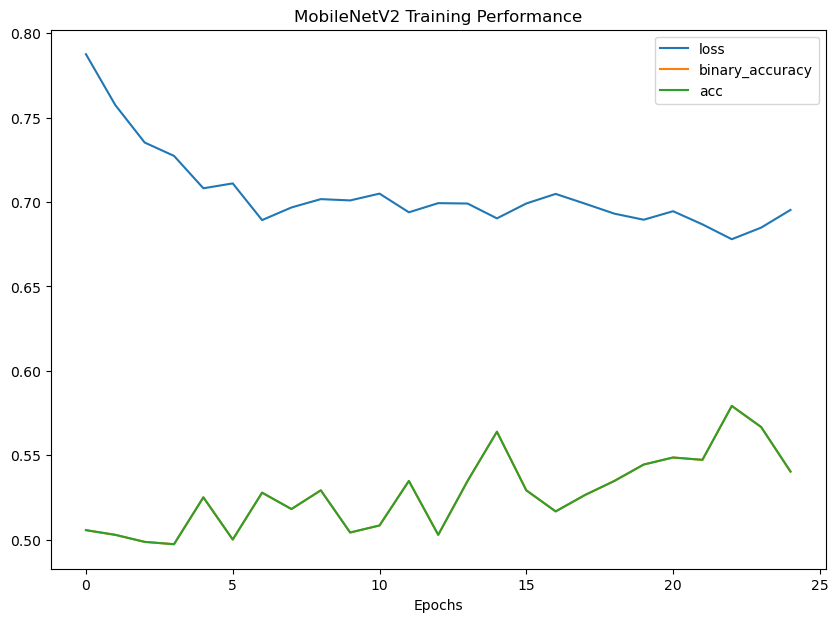

In [67]:
def view_performance(model_hist):
    graph = pd.DataFrame(model_hist.history).plot(figsize=(10,7), title="MobileNetV2 Training Performance", xlabel="Epochs")



view_performance(history)